# Find the optimum Rotation of CTIO Data in November 2016
==================================================================================================

- author : Sylvie Dagoret-Campagne
- date   : December 9th 2016


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from astropy.modeling import models
from astropy import units as u
from astropy import nddata
from astropy.io import fits
import re
import os

In [2]:
import ccdproc
print 'ccdproc version',ccdproc.__version__

from astropy.modeling import models

ccdproc version 1.0.1


In [3]:
from scipy import stats  
from scipy import ndimage
from datetime import datetime, timedelta
from mpl_toolkits.mplot3d import Axes3D
import scipy.signal

In [4]:
import bottleneck as bn  # numpy's masked median is slow...really slow (in version 1.8.1 and lower)
print 'bottleneck version',bn.__version__

bottleneck version 1.0.0


In [5]:
import photutils
from astropy.stats import sigma_clipped_stats
from photutils import daofind
from photutils import CircularAperture
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
#from photutils.background import Background2D
from photutils import Background2D, SigmaClip, MedianBackground

In [6]:
%load_ext Cython

In [7]:
from IPython.display import Image, display

In [8]:
import matplotlib
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

In [9]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (4, 4),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [10]:
############################################################################
def ensure_dir(f):
    d = os.path.dirname(f)
    if not os.path.exists(f):
        os.makedirs(f)
#########################################################################

In [11]:
inputdir="./cut_fitsimages"
object_name='HD14943'

In [12]:
outputdir="./spectrum_fitsimages"

In [13]:
ensure_dir(outputdir)

## Location of corrected images
----------------------------------

In [14]:
input_filelist=os.listdir(inputdir) 

In [15]:
if '.DS_Store' in input_filelist:
    input_filelist.remove('.DS_Store')
input_filelist=np.array(input_filelist)

In [16]:
#print input_filelist

In [17]:
indexes_files= [] # global list
filelist_fitsimages= []  # global list

In [18]:
#%%cython

import numpy as np
import re

def MakeFileList(inputdir,input_filelist):
    """
    MakeFileList : Make The List of files to open
    =============
    """
    
#    import numpy as np
#    import re
    indexes_files= [] # global list
    filelist_fitsimages= []  # global list
    index=0

    
    for file in input_filelist: # loop on directories, one per image       
            filename=inputdir+'/'+file
            if re.search('.*fits$',filename):  #example of filename filter
                index=index+1
                filelist_fitsimages.append(filename)
                indexes_files.append(index)
    return indexes_files, filelist_fitsimages

In [19]:
indexes_files, filelist_fitsimages=MakeFileList(inputdir,input_filelist)   # Make the list

In [20]:
indexes_files=np.array(indexes_files)
filelist_fitsimages=np.array(filelist_fitsimages)

In [21]:
print indexes_files

[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117]


In [22]:
sorted_indexes=np.argsort(indexes_files) # sort the file indexes

In [23]:
sorted_numbers=indexes_files[sorted_indexes]

In [24]:
print sorted_indexes

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116]


In [25]:
#sorted_files= [filelist_fitsimages[index] for index in sorted_indexes] # sort files
sorted_files=filelist_fitsimages[sorted_indexes]

In [26]:
#sorted_files

## Build full filename
----------------------------

In [27]:
sorted_filenames=[]
for file in sorted_files:
    #fullfilename=os.path.join(inputdir,file)
    fullfilename=file
    sorted_filenames.append(fullfilename)

In [28]:
#sorted_filenames=np.array(sorted_filenames)
sorted_filenames=np.copy(sorted_files)

In [29]:
print sorted_filenames.shape

(117,)


## Acces to data of  images
----------------------------------

In [30]:
all_dates = []
all_airmass = []
all_images = []
all_titles = []
all_header = []
all_img = []

In [31]:
%%cython

import numpy as np
from astropy.io import fits

def BuildImages(sorted_filenames,sorted_numbers,object_name):
    """
    BuildRawImages
    ===============
    """

    
    all_dates = []
    all_airmass = []
    all_images = []
    all_titles = []
    all_header = []
    all_expo = []
   
    NBFILES=sorted_filenames.shape[0]

    for idx in range(NBFILES):  
        
        file=sorted_filenames[idx]    
        
        hdu_list=fits.open(file)
        header=hdu_list[0].header
        #print header
        date_obs = header['DATE-OBS']
        airmass = header['AIRMASS']
        expo = header['EXPTIME']
        num=sorted_numbers[idx]
        title=object_name+" z= {:3.2f} Nb={}".format(float(airmass),num)
        image_corr=hdu_list[0].data
        image=image_corr
        
        all_dates.append(date_obs)
        all_airmass.append(float(airmass))
        all_images.append(image)
        all_titles.append(title)
        all_header.append(header)
        all_expo.append(expo)
        hdu_list.close()
        
    return all_dates,all_airmass,all_images,all_titles,all_header,all_expo

In [32]:
all_dates,all_airmass,all_images,all_titles,all_header,all_expo=BuildImages(sorted_files,sorted_numbers,object_name)

## Show images
-----------------------

In [33]:
len(all_images)

117

In [85]:
%%cython
import numpy as np
import matplotlib.pyplot as plt
    
def ShowImages(all_images,all_titles,object_name):
    """
    ShowRawImages: Show the raw images without background subtraction
    ==============
    """
    NBIMAGES=len(all_images)
    MAXIMGROW=int(NBIMAGES/5)+1
    thex0 = []
    f, axarr = plt.subplots(MAXIMGROW,5,figsize=(20,100))
    for index in np.arange(0,NBIMAGES):
        ix=index%5
        iy=index/5
        xprofile=np.sum(all_images[index],axis=0)
        x0=np.where(xprofile==xprofile.max())[0][0]
        thex0.append(x0)
        im=axarr[iy,ix].imshow(all_images[index],vmin=-10,vmax=50)
        axarr[iy,ix].set_title(all_titles[index])
    title='Images of '.format(object_name)
    plt.suptitle(title,size=16)
    return thex0

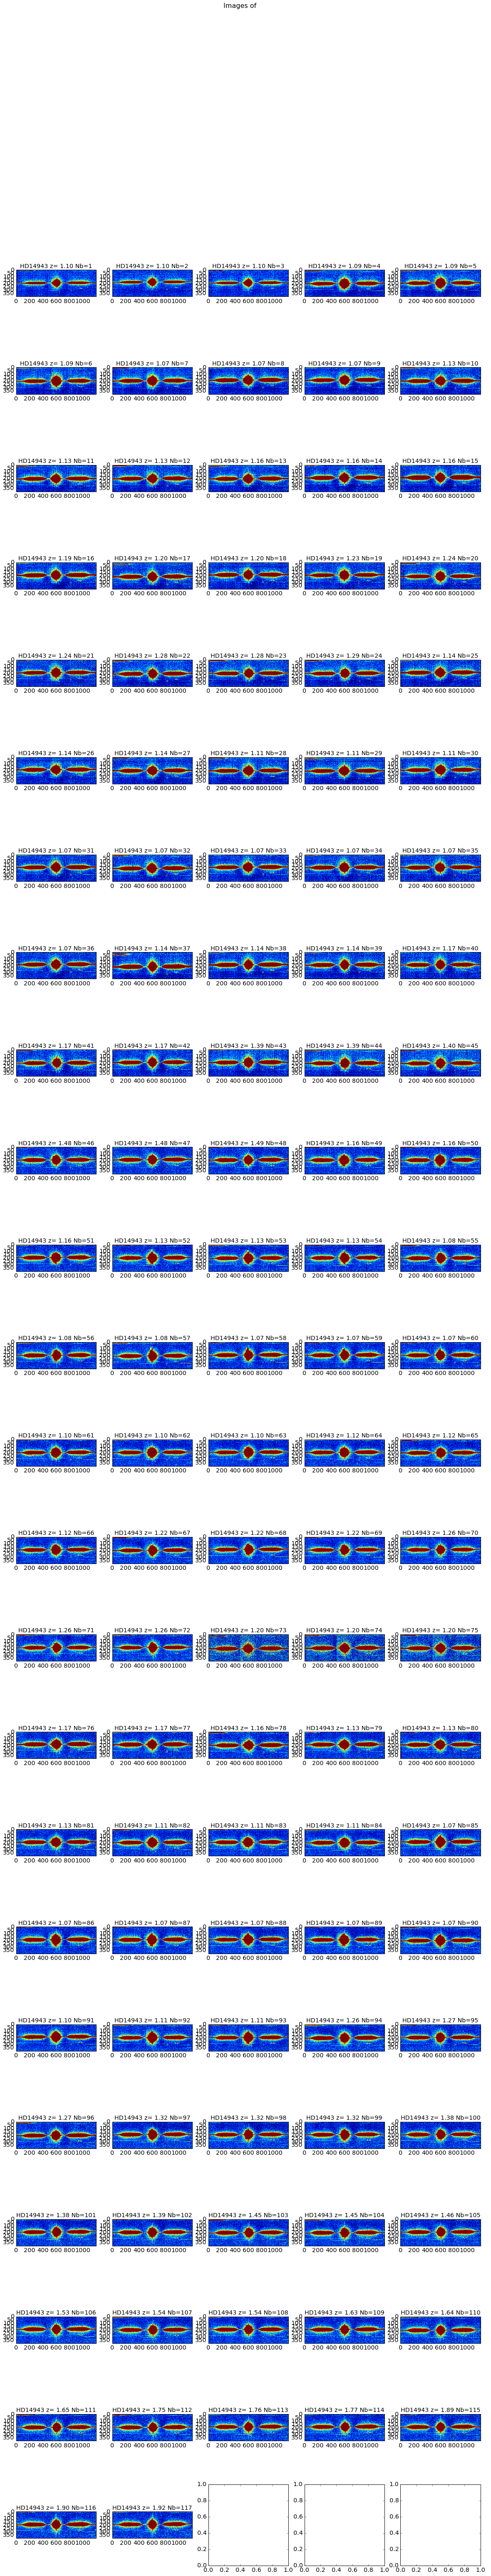

In [86]:
thex0=ShowImages(all_images,all_titles,object_name)

### Shows the transverse profile

In [53]:
DeltaX=600
w=20
ws=80

In [59]:
%%cython
import numpy as np
import matplotlib.pyplot as plt
    
def ShowTransverseProfile(all_images,all_titles,object_name,all_expo):
    """
    ShowTransverseProfile: Show the raw images without background subtraction
    =====================
    """

    NBIMAGES=len(all_images)
    MAXIMGROW=int(NBIMAGES/5)+1
    DeltaX=600
    w=20
    ws=80
    thespectra= []
    they0= []
    f, axarr = plt.subplots(MAXIMGROW,5,figsize=(20,100))
    for index in np.arange(0,NBIMAGES):
        ix=index%5
        iy=index/5
        data=np.copy(all_images[index])
        data[:,DeltaX-ws:DeltaX+ws]=0
        yprofile=np.sum(data,axis=1)/all_expo[index]
        ymin=1
        ymax=yprofile.max()
        y0=np.where(yprofile==ymax)[0][0]
        they0.append(y0)
        #im=axarr[iy,ix].imshow(data,vmin=-10,vmax=50)
        axarr[iy,ix].semilogy(yprofile)
        axarr[iy,ix].semilogy([y0,y0],[ymin,ymax],'r-')
        axarr[iy,ix].semilogy([y0-w,y0-w],[ymin,ymax],'k-')
        axarr[iy,ix].semilogy([y0+w,y0+w],[ymin,ymax],'k-')
        spectrum2D=np.copy(data[y0-w:y0+w,:])
        xprofile=np.sum(spectrum2D,axis=0)
        thespectra.append(xprofile/(2.*float(w))/all_expo[index])
        axarr[iy,ix].set_title(all_titles[index])
        axarr[iy,ix].grid(True)
    title='Spectrum tranverse profile '.format(object_name)
    plt.suptitle(title,size=16)
    return thespectra,they0

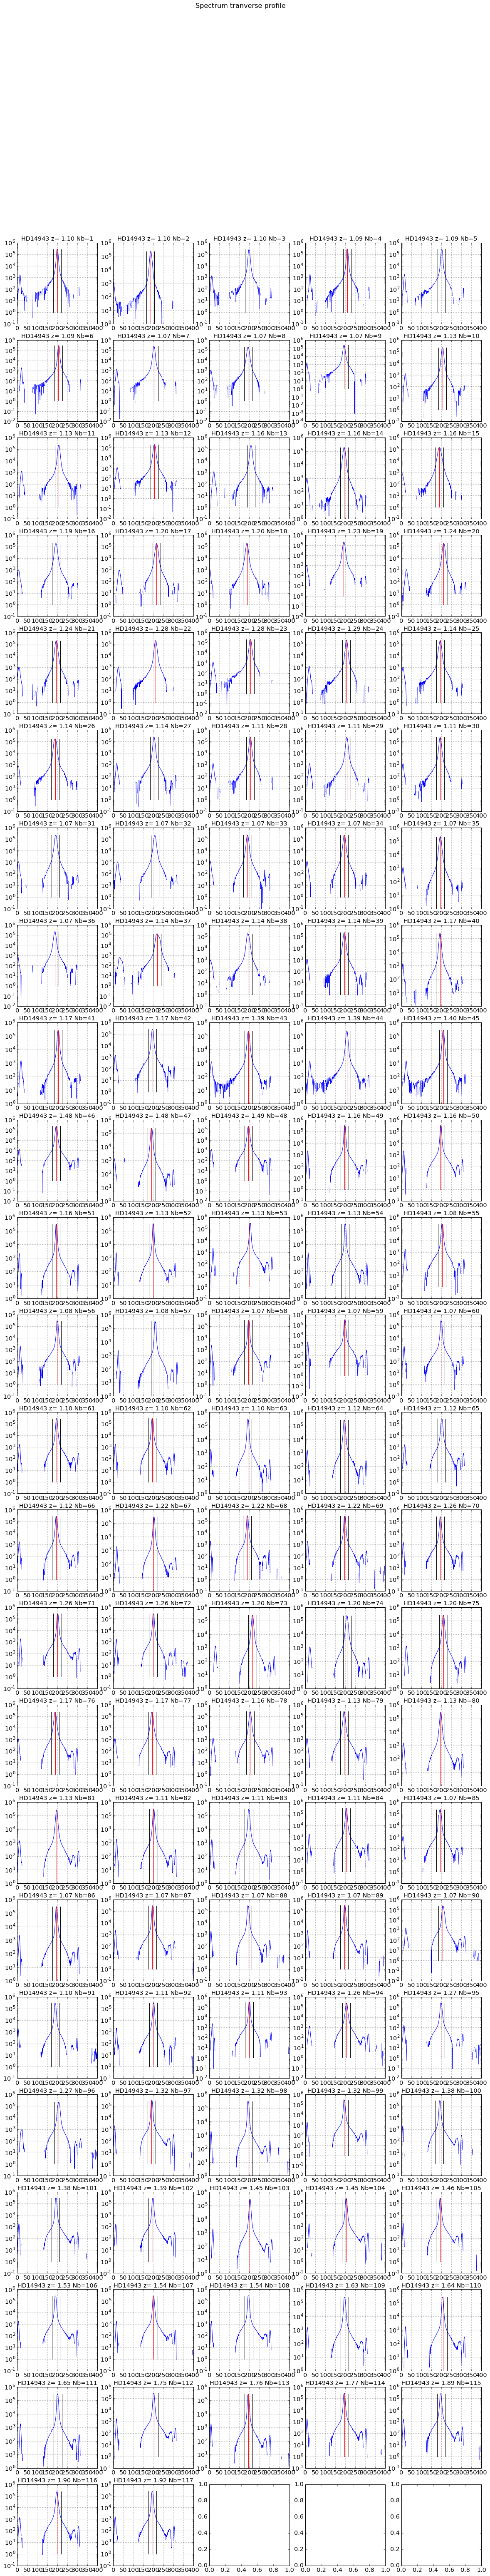

In [60]:
thespectra,they0=ShowTransverseProfile(all_images,all_titles,object_name,all_expo)

In [78]:
%%cython
import numpy as np
import matplotlib.pyplot as plt
    
def ShowSpectrumProfile(spectra,all_titles,object_name):
    """
    ShowSpectrumProfile: Show the raw images without background subtraction
    =====================
    """
    NBSPEC=len(spectra)
    MAXIMGROW=int(NBSPEC/5)+1
    
    f, axarr = plt.subplots(MAXIMGROW,5,figsize=(20,100))
    for index in np.arange(0,NBSPEC):
        ix=index%5
        iy=index/5
        axarr[iy,ix].plot(spectra[index])
        axarr[iy,ix].set_title(all_titles[index])
        axarr[iy,ix].grid(True)
        axarr[iy,ix].set_ylim(0.,200.)
    title='Spectrum 1D profile '.format(object_name)
    plt.suptitle(title,size=16)

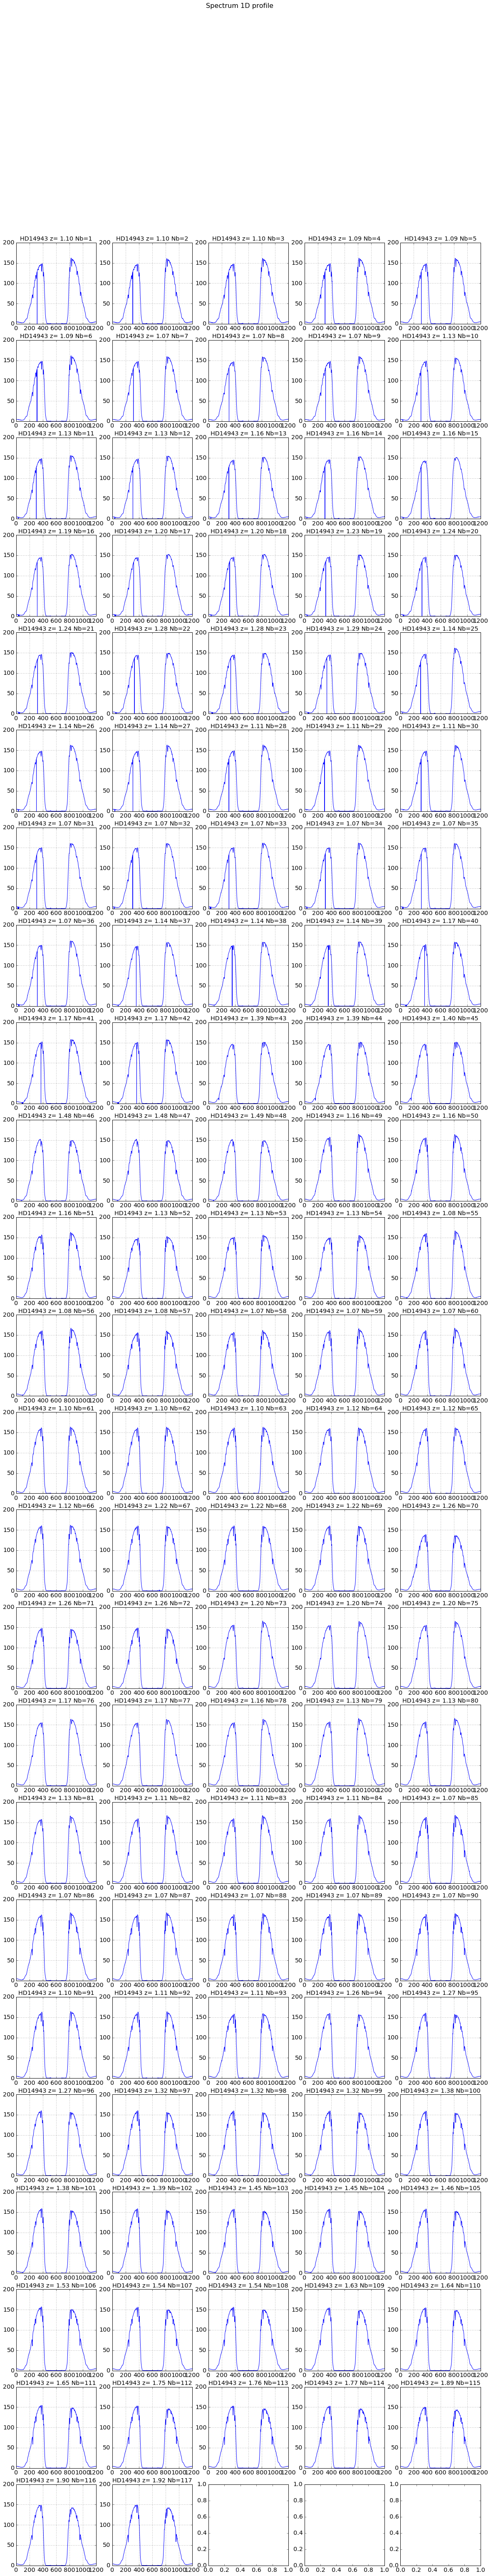

In [79]:
ShowSpectrumProfile(thespectra,all_titles,object_name)

In [62]:
print they0

[200, 186, 198, 209, 201, 206, 203, 194, 193, 205, 208, 206, 208, 194, 190, 193, 216, 188, 192, 211, 195, 212, 205, 205, 194, 190, 204, 205, 207, 194, 192, 208, 191, 195, 194, 188, 219, 193, 195, 193, 204, 196, 196, 207, 209, 195, 191, 196, 196, 196, 194, 198, 202, 198, 203, 199, 208, 195, 196, 197, 196, 194, 192, 194, 201, 194, 202, 189, 195, 194, 201, 199, 216, 208, 210, 190, 194, 204, 194, 196, 197, 201, 197, 204, 194, 195, 195, 192, 195, 206, 189, 200, 199, 205, 197, 207, 191, 193, 193, 191, 192, 197, 202, 203, 193, 193, 202, 197, 197, 208, 203, 203, 196, 196, 198, 199, 196]


In [88]:
print thex0

[607, 600, 598, 602, 605, 605, 604, 596, 603, 604, 598, 605, 598, 596, 597, 597, 603, 598, 595, 598, 596, 603, 605, 605, 596, 598, 605, 604, 596, 604, 597, 596, 598, 596, 594, 598, 599, 596, 597, 595, 604, 597, 597, 604, 598, 597, 599, 596, 598, 598, 599, 604, 605, 604, 603, 604, 600, 599, 598, 597, 596, 598, 605, 598, 605, 598, 604, 604, 598, 598, 604, 604, 599, 603, 603, 603, 597, 605, 597, 596, 596, 604, 597, 603, 602, 598, 598, 602, 598, 602, 602, 604, 604, 597, 597, 595, 602, 599, 603, 602, 603, 597, 605, 598, 603, 599, 605, 598, 597, 599, 605, 605, 599, 604, 598, 597, 598]


### Test rotation optimum
----------------------------

In [ ]:
from scipy import stats 
from scipy import ndimage

In [71]:
sel=0

In [128]:
image_sel=np.copy(all_images[sel])
y0=they0[sel]
x0=thex0[sel]

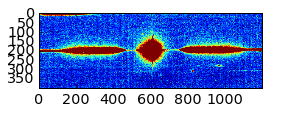

In [129]:
plt.imshow(image_sel,vmin=-10,vmax=50)

In [155]:
region=np.copy(image_sel[y0-100:y0+100,x0-500:x0+500])
#region[:,500-100:500+100]=0
data=np.copy(region)

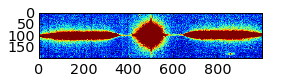

In [156]:
plt.imshow(data,vmin=-10,vmax=50)

In [163]:
NBINSY=data.shape[0]
NBINSX=data.shape[1]
the_sum=np.zeros(NBINSX)
the_ysum=np.zeros(NBINSX)
for y in range(NBINSY):
    the_sum+=data[y,:]
    the_ysum+=float(y)*data[y,:]
yaver=the_ysum/the_sum

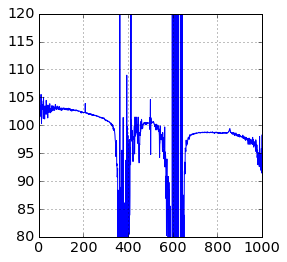

In [164]:
plt.plot(yaver)
plt.ylim(80,120)
plt.grid(True)

### prepare outputfilename

In [ ]:
newfullfilenames=[]
for idx,file in np.ndenumerate(sorted_files):
    short_infilename=file.split("/")[2]
    short_partfilename=re.findall('^cutimg_(.*)',short_infilename)
    short_outfilename='spec_'+short_partfilename[0]
    newfullfilename=os.path.join(outputdir,short_outfilename)
    newfullfilenames.append(newfullfilename)

### Save outputfilename

In [ ]:
for idx,file in np.ndenumerate(newfullfilenames):
    prihdu = fits.PrimaryHDU(header=all_header[idx[0]],data=images_cut[idx[0]])
    thdulist = fits.HDUList(prihdu)
    thdulist.writeto(file,clobber=True)

In [ ]:
!ls

In [ ]:
# !ls -l cut_fitsimages